# Jul 5th, 2022 (mg finalize)

**Motivation**:  <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from model.configuration import Config
from model.mouse import Mice
from figures.fighelper import *
from analysis.bootstrap import *
from analysis.network import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Fig dir

In [2]:
nn = 512
fig_dir = 'Fig3_OCs'
fig_dir = pjoin(fig_base_dir, 'paper2.0', f'n{nn}', fig_dir)
os.makedirs(fig_dir, exist_ok=True)
print(fig_dir)

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/n512/Fig3_OCs

## Prepare (512)

In [3]:
mice = Mice(nn)
pal, _BOLD, _CAS, _CAF = prepare_palette(0.6)

In [4]:
task = 'rest'

num_k, p = 7, 20
perc = f'p{p}-sample'
props_base = {
    'kw_kmeans': {'n_init': 100},
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': task,
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

bt = BootStrap(**props_ca)

props_bo['num_k'] += 1
bt_bo = BootStrap(**props_bo)

mice.setup_func_data(task, band_ca=(0.01, 0.5))
bt_cas = BootStrap(**props_ca)

mice.setup_func_data(task, band_ca=0.5)
bt_caf = BootStrap(**props_ca)

bt_dict = {
    _BOLD: bt_bo,
    _CAS: bt_cas,
    _CAF: bt_caf,
}

## MG explore

In [10]:
kws_show = {
    'vmin': 0.2,
    'vmax': 0.8,
    'mask_thresh': 1 / num_k,
    'figsize': (40, 7.7),
    'ylabel_fontsize': 15,
    'contour': False,
}

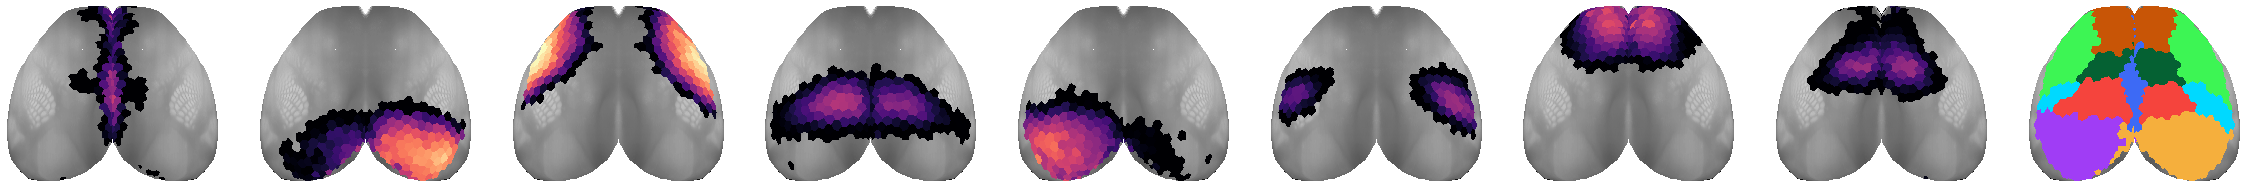

In [11]:
_ = bt.show(
    data=avg(bt_bo.pi_prune),
    **kws_show,
)

In [12]:
pi = avg(bt_bo.run_pi)
pip = avg(bt_bo.pi_prune)

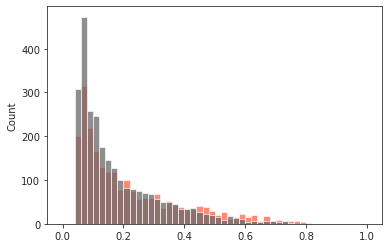

In [13]:
sns.histplot(pip[pip > 0.05], color='tomato', bins=np.linspace(0, 1, 51))
sns.histplot(pi[pi > 0.05], color='dimgrey', bins=np.linspace(0, 1, 51))
plt.show()

## This is final (below)

---

start

---

In [14]:
pip, idx_1, idx_2 = bt_bo._merge_vis(0.5, bt_bo.pi_prune)

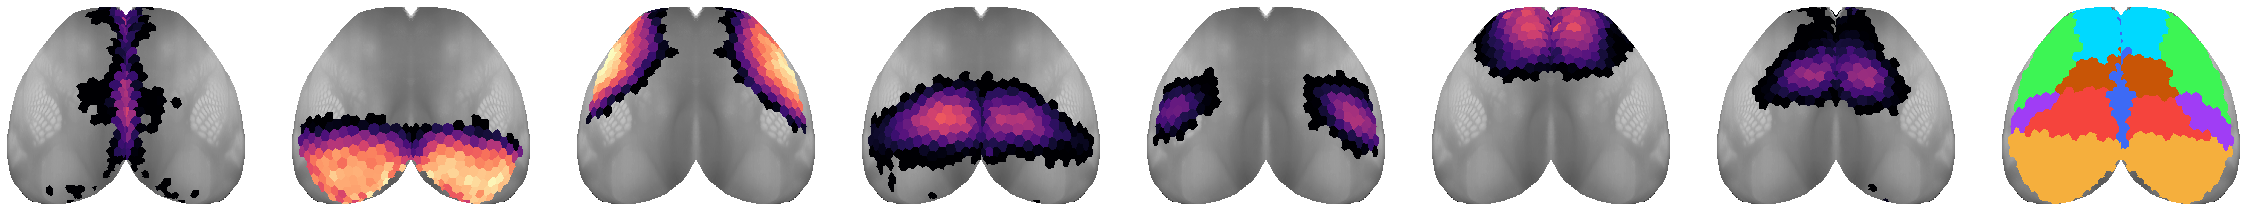

In [16]:
_ = bt.show(
    data=avg(pip),
    **kws_show,
)

In [17]:
pi, idx_1, idx_2 = bt_bo._merge_vis(0.5, bt_bo.run_pi)

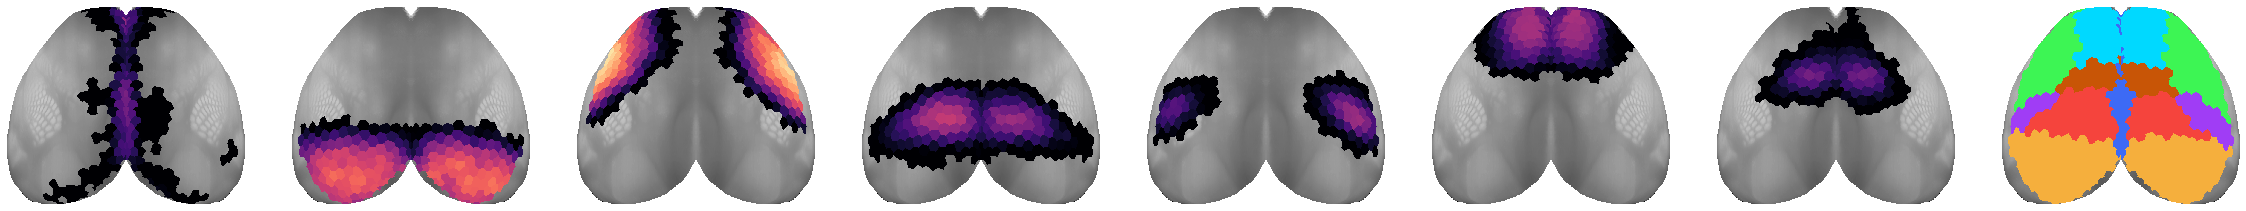

In [18]:
_ = bt.show(
    data=avg(pi),
    **kws_show,
)

In [20]:
dlist = []
for thres in tqdm(np.linspace(0, 0.7, 71)):
    pi, *_ = bt_bo._merge_vis(thres, bt_bo.run_pi)
    ovp, disj = bt.symmetry_score(avg(pi))
    dlist.append({
        'thres': [thres] * len(ovp),
        'label': ['ovp'] * len(ovp),
        'score': ovp.values(),
        'oc_idx': ovp.keys(),
    })
    dlist.append({
        'thres': [thres] * len(ovp),
        'label': ['disj'] * len(ovp),
        'score': disj.values(),
        'oc_idx': disj.keys(),
    })
df = pd.DataFrame(merge_dicts(dlist))

  0%|          | 0/71 [00:00<?, ?it/s]

<AxesSubplot:xlabel='thres', ylabel='score'>

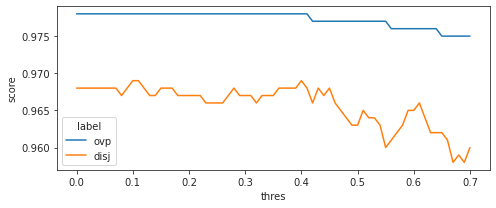

In [25]:
fig, ax = create_figure(1, 1, (7, 3))
sns.lineplot(
    data=df.loc[df['oc_idx'] == -1],
    x='thres',
    y='score',
    hue='label',
    ax=ax,
)

<AxesSubplot:xlabel='thres', ylabel='score'>

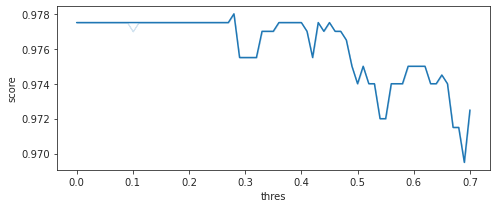

In [28]:
fig, ax = create_figure(1, 1, (7, 3))
sns.lineplot(
    data=df.loc[df['oc_idx'] != -1],
    x='thres',
    y='score',
    estimator=np.nanmedian,
    ci=False,
    ax=ax,
)

In [60]:
df_mean = df.loc[df['oc_idx'] != -1].groupby(['thres']).mean().drop(columns='oc_idx').reset_index()
df_median = df.loc[df['oc_idx'] != -1].groupby(['thres']).median().drop(columns='oc_idx').reset_index()

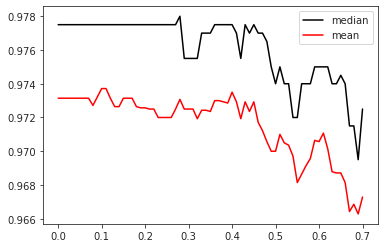

In [61]:
plt.plot(df_median['thres'], df_median['score'], color='k', label='median')
plt.plot(df_mean['thres'], df_mean['score'], color='r', label='mean')
plt.legend()
plt.show()

In [62]:
i1 = df_mean['score'][20:].argmax()
df_mean.iloc[[20 + i1]]

,thres,score
40,0.4,0.9735


In [63]:
i1

20

In [64]:
i2 = df_median['score'][40:].argmax()
df_median.iloc[[40 + i2]]

,thres,score
40,0.4,0.9775


In [65]:
df_mean['score'] = (df_mean['score'] + df_median['score']) / 2

[<matplotlib.lines.Line2D object at 0x7f41dedf20d0>]

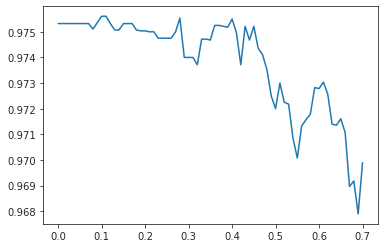

In [66]:
plt.plot(df_mean['thres'], df_mean['score'])

In [72]:
delta = 30
i = df_mean['score'][delta:].argmax()
df_mean.iloc[[delta + i]]

,thres,score
40,0.4,0.9755


In [92]:
dlist = []
for thres in tqdm(np.linspace(0.3, 0.5, 101)):
    pi, *_ = bt_bo._merge_vis(thres, bt_bo.run_pi)
    ovp, disj = bt.symmetry_score(avg(pi), decimals=10)
    dlist.append({
        'thres': [thres] * len(ovp),
        'label': ['ovp'] * len(ovp),
        'score': ovp.values(),
        'oc_idx': ovp.keys(),
    })
    dlist.append({
        'thres': [thres] * len(ovp),
        'label': ['disj'] * len(ovp),
        'score': disj.values(),
        'oc_idx': disj.keys(),
    })
df = pd.DataFrame(merge_dicts(dlist))

  0%|          | 0/101 [00:00<?, ?it/s]

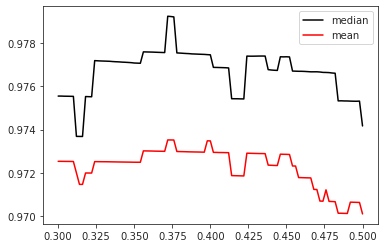

In [96]:
df_mean = df.loc[df['oc_idx'] != -1].groupby(['thres']).mean().drop(columns='oc_idx').reset_index()
df_median = df.loc[df['oc_idx'] != -1].groupby(['thres']).median().drop(columns='oc_idx').reset_index()

plt.plot(df_median['thres'], df_median['score'], color='k', label='median')
plt.plot(df_mean['thres'], df_mean['score'], color='r', label='mean')
plt.legend()
plt.show()

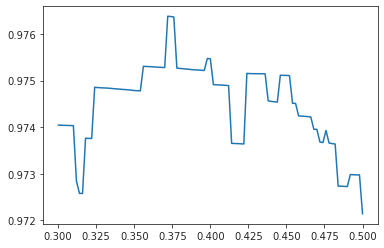

In [97]:
df_mean['score'] = (df_mean['score'] + df_median['score']) / 2
plt.plot(df_mean['thres'], df_mean['score'])
plt.show()

In [98]:
i = df_mean['score'].argmax()
df_mean.iloc[[i]]

,thres,score
36,0.372,0.976379


## This is final (above)

---

end

---

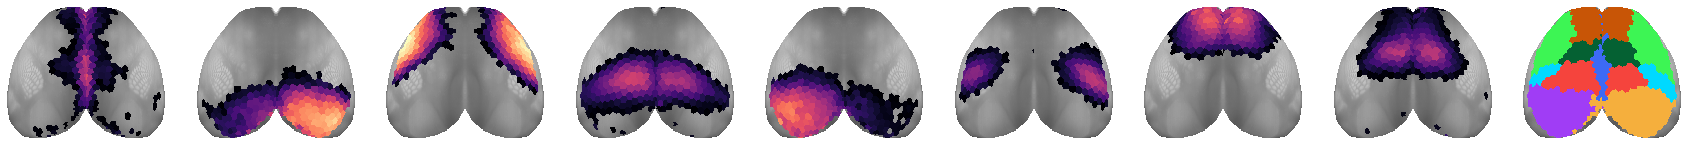

In [118]:
_ = bt.show(
    data=avg(bt_bo.pi_prune),
    vmin=0.1,
    vmax=0.8,
    mask_thresh=0.1,
    figsize=(30, 5),
    ylabel_fontsize=19,
    contour=False,
)

In [126]:
idx_1, idx_2

(1, 4)

In [127]:
y = bt_bo.pi_prune.copy()
a = y[..., idx_1, :][..., bt.l_ids]
b = y[..., idx_2, :][..., bt.r_ids]

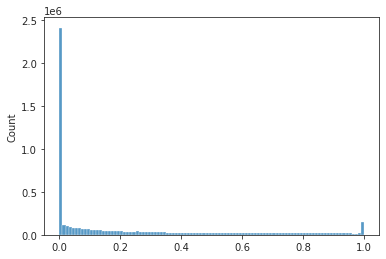

In [128]:
sns.histplot(a[a.nonzero()], bins=np.linspace(0, 1, 101));

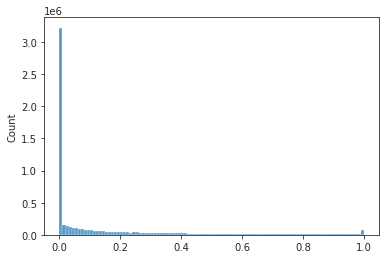

In [129]:
sns.histplot(b[b.nonzero()], bins=np.linspace(0, 1, 101));

In [139]:
y = bt_bo.pi_prune.copy()
y[..., idx_1, :][..., bt.l_ids] = 0.0
y[..., idx_2, :][..., bt.r_ids] = 0.0

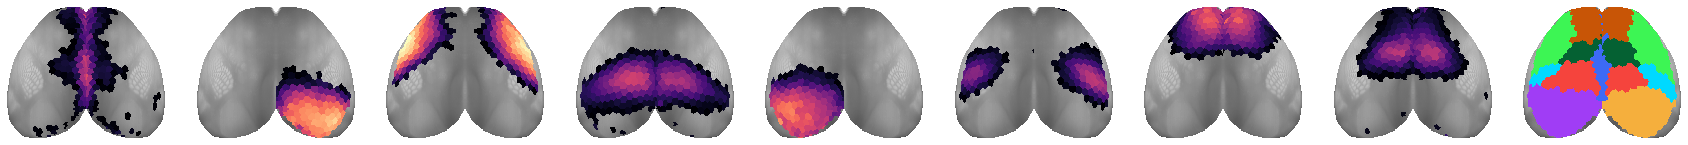

In [140]:
_ = bt.show(
    data=avg(y),
    vmin=0.1,
    vmax=0.8,
    mask_thresh=0.1,
    figsize=(30, 5),
    ylabel_fontsize=19,
    contour=False,
)

In [141]:
y[..., idx_1, :] += y[..., idx_2, :]
y = y[..., np.delete(range(bt.num_k), idx_2), :]

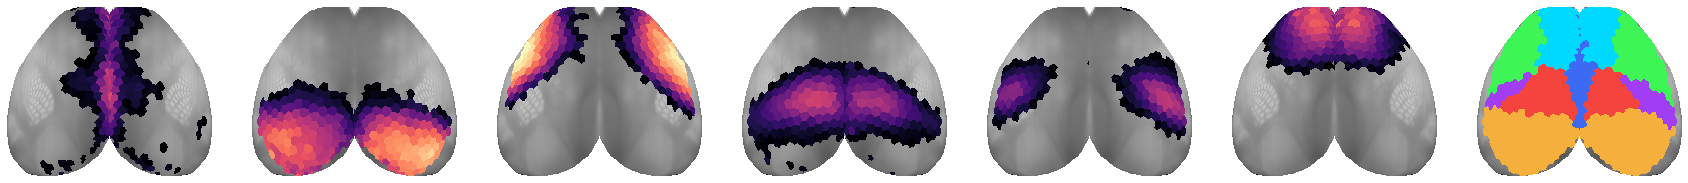

In [142]:
_ = bt.show(
    data=avg(y),
    vmin=0.1,
    vmax=0.8,
    mask_thresh=0.1,
    figsize=(30, 5),
    ylabel_fontsize=19,
    contour=False,
)

In [143]:
y /= np.nansum(y, -2, keepdims=True)

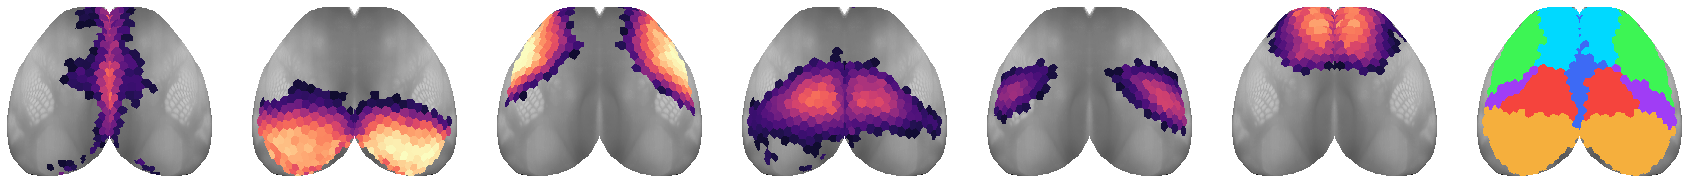

In [146]:
_ = bt.show(
    data=avg(y),
    vmin=0.1,
    vmax=0.8,
    mask_thresh=0.16,
    figsize=(30, 5),
    ylabel_fontsize=19,
    contour=False,
)